**Bibliotecas**

In [3]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd
import zipfile
import shutil
import numpy as np
import glob
import random
import pandas as pd
import matplotlib.pyplot as plt


from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

**Montar o google drive no Colab**

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

**Importar arquivos de configuração do Kaglle**

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fabiobasson","key":"d71cbfdfd23379909173204eac74cf96"}'}

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### ** Download dos dados / descompactando os dados**

In [6]:
!kaggle datasets download phylake1337/fire-dataset

 98% 379M/387M [00:03<00:00, 148MB/s]
100% 387M/387M [00:03<00:00, 122MB/s]


In [7]:
!unzip -qq fire-dataset.zip

**Criando o Diretorio Df e unificando os dados dentro dele (não utilizado)**

In [6]:
! mkdir df
!cp -r fire_dataset/fire_images/* df
! cp -r fire_dataset/non_fire_images/* df

In [141]:
! rm -rf new_fire

**Tentado dividir os dados em treino, validação e teste (sem sucesso)**

In [140]:
import os, shutil, pathlib

original_dir = pathlib.Path("df")
new_base_dir = pathlib.Path("new_fire")

def make_subset(subset_name, start_index, end_index):
    for category in ("fire","non_fire"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.png" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=1, end_index=300)
make_subset("validation", start_index=301, end_index=600)
make_subset("test", start_index=600, end_index=999)

FileNotFoundError: ignored

### Data Preprocessing

In [7]:
#ignorar esse codigo

fire_dir = glob.glob('fire_dataset/fire_images/*.png')

In [8]:
#ignorar esse codigo

import os, shutil, pathlib

original_dir = pathlib.Path("df")
#make_subset("train", start_index=1, end_index=300)
train_dir = os.path.join(original_dir)
validation_dir = os.path.join(original_dir)

## **This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.**

In [8]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [9]:
IMG_SHAPE = 256
BATCH_SIZE = 20

In [10]:
datagen = ImageDataGenerator(rescale=1./255,
                            #rotation_range = 40,
                            #width_shift_range = 0.2,
                            #height_shift_range = 0.2,
                            #shear_range = 0.2,
                            #zoom_range = 0.2,
                            horizontal_flip = True)

In [11]:
train_generator = datagen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory="fire_dataset",
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE),
                                               class_mode='binary')

Found 999 images belonging to 2 classes.


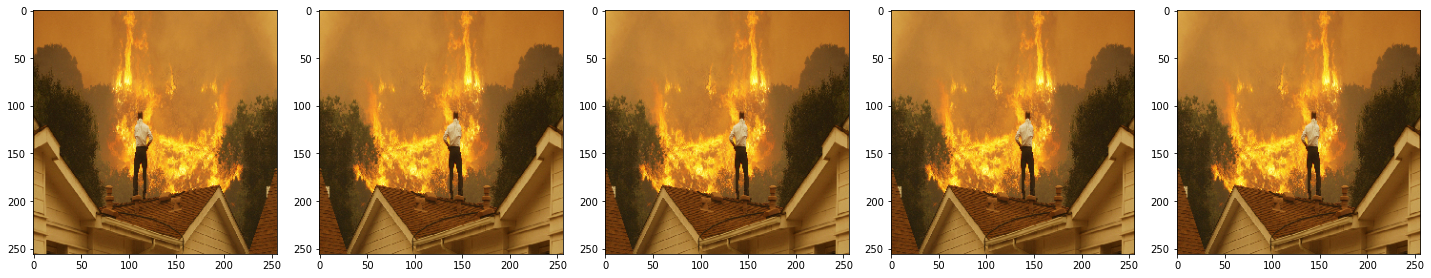

In [12]:
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [13]:
image_gen_val = ImageDataGenerator(rescale=1./255)

validation_generator = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory="fire_dataset",
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 999 images belonging to 2 classes.


In [56]:
#ignorar esse codigo

from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu', input_shape=(256,256,)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

#x = layers.Flatten()(inception_v3.output)
#x = layers.BatchNormalization()(x)
#x = layers.Dense(1024,activation='relu')(x)
#x = layers.Dropout(0.2)(x)                  
#x = layers.Dense(1,activation='sigmoid')(x)           

#model1 = Model(inception_v3.input, x) 


In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

**Compilando o Modelo**

In [15]:
model.compile(optimizer = Adam(learning_rate=0.0001), 
               loss = 'binary_crossentropy', 
               metrics =['accuracy'])

In [16]:
model.summary()   

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       1

In [17]:
callbacks_list = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                         patience=4,
                                         verbose=0),
    tf.keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=12,
        #restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        monitor="val_accuracy",
        save_best_only=True,
    ),

]

In [23]:
history = model.fit_generator(train_generator,
                               epochs=4,
                               #verbose=0,
                               callbacks=callbacks_list, 
                               #validation_split=0.2,
                               #class_weight=class_weight_,
                               workers=4,
                               use_multiprocessing=True,
                               validation_data=validation_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/4
50/50 [==============================] - 220s 4s/step - loss: 0.7037 - accuracy: 0.4895 - val_loss: 0.3614 - val_accuracy: 0.4064
Epoch 2/4
50/50 [==============================] - 214s 4s/step - loss: 0.2594 - accuracy: 0.2523 - val_loss: 0.2796 - val_accuracy: 0.1271
Epoch 3/4
50/50 [==============================] - 247s 5s/step - loss: 0.3919 - accuracy: 0.2132 - val_loss: 0.2096 - val_accuracy: 0.3574
Epoch 4/4
50/50 [==============================] - 214s 4s/step - loss: 0.1711 - accuracy: 0.2352 - val_loss: 0.1724 - val_accuracy: 0.1832


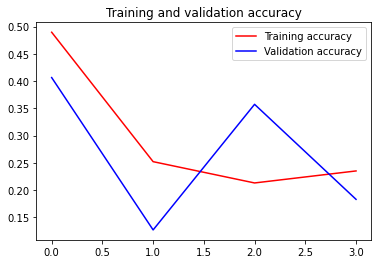

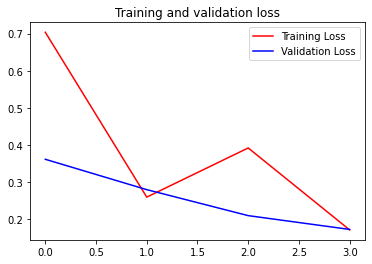

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [25]:
model = tf.keras.models.load_model("best_model.h5")

val_acc1 = model.evaluate(validation_generator)[1]
print("validation_accuracy: " + str(val_acc1))

50/50 [==============================] - 57s 1s/step - loss: 0.3614 - accuracy: 0.4064
validation_accuracy: 0.4064064025878906


**the VGG16 model.**

In [28]:
conv_base = tf.keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58900480/58889256 [==============================] - 2s 0us/step


**### InceptionV3**

In [18]:
inception_v3 = InceptionV3(input_shape=(256,256,3),
                           weights='imagenet',
                           include_top=False)
inception_v3.trainable = False

87924736/87910968 [==============================] - 1s 0us/step


In [19]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

model1.compile(optimizer = Adam(learning_rate=0.0001), 
               loss = 'binary_crossentropy', 
               metrics =['acc'])

In [ ]:
history = model1.fit(train_generator,
                               epochs=20,
                               verbose=1,
                               validation_data=validation_generator)

Epoch 1/20
36/50 [====================>.........] - ETA: 44s - loss: 2.2303 - acc: 0.3060

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
val_acc1= model2.evaluate(validation_generator)[1]
print("validation_accuracy: " + str(val_acc1))

### EfficientNet B0

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
efficientnet_b0 = EfficientNetB0(include_top=False,
                             weights="imagenet",
                             input_shape=(256,256,3))
efficientnet_b0.trainable = False

In [ ]:
x = layers.Flatten()(efficientnet_b0.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(1024,activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(1,activation='sigmoid')(x)           

model2 = Model(efficientnet_b0.input, x) 

model2.compile(optimizer = Adam(lr=0.0001), 
               loss = 'binary_crossentropy', 
               metrics =['acc'])

In [ ]:
history = model2.fit_generator(train_generator,
                               epochs=50,
                               verbose=0,
                               validation_data=validation_generator)

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
val_acc2 = model2.evaluate(validation_generator)[1]
print("validation_accuracy: " + str(val_acc2))

### EfficientNet B7

In [ ]:
from tensorflow.keras.applications import EfficientNetB7

In [ ]:
efficientnet_b7 = EfficientNetB7(include_top=False,
                                 weights="imagenet",
                                 input_shape=(256,256,3))
efficientnet_b7.trainable = False

In [ ]:
x = layers.Flatten()(efficientnet_b7.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(1024,activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(1,activation='sigmoid')(x)           

model3 = Model(efficientnet_b7.input, x) 

model3.compile(optimizer = Adam(lr=0.0001), 
               loss = 'binary_crossentropy', 
               metrics =['acc'])

In [ ]:
history = model3.fit_generator(train_generator,epochs=50,
                               verbose=0,
                               validation_data=validation_generator)

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
val_acc3 = model3.evaluate(validation_generator)[1]
print("validation_accuracy: " + str(val_acc3))

### Model Comparison

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
acc = [val_acc1,val_acc2,val_acc3]
model = ['InceptionV3','EfficientNetB0','EfficientNetB7']
ax.bar(model,acc)
plt.show()